# IMPORTS

In [1]:
# data visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# logger.
import pickle
import mlflow

In [2]:
# tensor calculus backend.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# neural networks abstractions.
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, \
                                    Flatten, \
                                    Dense, \
                                    Dropout, \
                                    AveragePooling2D

# monitoring metrics and callbacks.
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# confere data.
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import cv2
import natsort
import seaborn as sns

2023-08-06 16:22:39.081015: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 16:22:39.151929: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 16:22:39.152444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 16:22:40.023606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dev parameters

In [3]:
import sys
sys.path.insert(1, '../')

# get parameters.
from dev_modules.vcs_params import params_dataset
from dev_modules.vcs_params import params_train

# import custom model.
from dev_modules.vcs_model import model_class

# LOGGER

In [4]:
mlflow.tensorflow.autolog()
mlflow.start_run(run_name=params_train.RUN_NAME)

mlflow.log_artifact("../dev_modules/")
mlflow.log_params(model_class.TRAIN_HYPER)

In [5]:
tf.keras.utils.set_random_seed(params_train.RANDOM_SEED)

# TRAINING GEN

In [6]:
dir_train = os.path.join("..",
                         params_dataset.DATASET_ROOT_DIR,
                         params_dataset.DATASET_TYPE,
                         params_dataset.TRAIN_DIR)

# training
train_gen = ImageDataGenerator(**params_train.TRAINING_GEN_PARAMS)

print('Training set: ')
train_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='training',
                                          **params_train.TRAINING_FLOW_PARAMS)
print(train_set.class_indices)

train_files = train_set._filepaths
train_files = natsort.natsorted(train_files)

print('\nValidation set: ')
valid_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='validation',
                                          **params_train.TRAINING_FLOW_PARAMS)
print(valid_set.class_indices)

valid_files = valid_set._filepaths
valid_files = natsort.natsorted(valid_files)

Training set: 
Found 892 images belonging to 2 classes.
{'0_utilizavel': 0, '1_defeituoso': 1}

Validation set: 
Found 222 images belonging to 2 classes.
{'0_utilizavel': 0, '1_defeituoso': 1}


In [7]:
train_outputs_dir = os.path.join('.', params_train.TRAIN_OUTPUTS_DIR)
TRAIN_FILES = os.path.join(train_outputs_dir, params_train.TRAIN_FILES)
VAL_FILES = os.path.join(train_outputs_dir, params_train.VAL_FILES)
os.makedirs(train_outputs_dir)

for sets_files in zip([TRAIN_FILES, VAL_FILES], [train_files, valid_files]):
    with open(sets_files[0], 'wb') as file:
        pickle.dump(sets_files[1], file)

# BUILD MODEL

In [8]:
model = model_class.minimal_CNN_MCU(params_dataset.IMAGE_SIZE)

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(params_train.LEARNING_RATE),
    loss=keras.losses.binary_crossentropy,
    
    metrics=[# critical for success.
             keras.metrics.Recall(),
             keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(),
             # auxiliar.
             keras.metrics.FalseNegatives(),
             keras.metrics.FalsePositives()],
)

model.build((1, *params_dataset.IMAGE_SIZE))
model.summary(expand_nested=True)

Model: "minimal_cnn_mcu"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 4193      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d (Conv2D)            (None, 128, 128, 2)       20       |
|                                                               |
| average_pooling2d (Averag  (None, 64, 64, 2)         0        |
| ePooling2D)                                                   |
|                                                               |
| conv2d_1 (Conv2D)          (None, 64, 64, 4)         76       |
|                                                               |
| average_pooling2d_1 (Aver  (None, 32, 32, 4)         0        |
| agePooling2D)                                                 |
|                                                               |
| flatten (Flatten)          (None, 4096)              0        |
|                                                               |
| dense (D

# TRAINING LOOP

In [10]:
epochs = params_train.NUM_EPOCHS

checkpoint_dir = os.path.join('.', params_train.MODELS_DIR)
os.makedirs(checkpoint_dir, exist_ok=True)
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir,
                                                 "last")
                                    + params_train.MODEL_EXTENSION),
    
    keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir,
                                                 "best")
                                    + params_train.MODEL_EXTENSION,
                                    **params_train.SAVE_BEST_PARAMS),
    
    keras.callbacks.TensorBoard(log_dir=params_train.TENSORFLOW_DIR),
]

In [11]:
history = model.fit(train_set,
                    validation_data=valid_set,
                    callbacks=callbacks,
                    **params_train.FIT_PARAMS)

2023/08/06 16:22:41 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "minimal_cnn_mcu" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2023/08/06 16:22:41 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2023/08/06 16:22:41 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 0.7664 - recall: 0.7556 - binary_accuracy: 0.6043 - precision: 0.6459 - false_negatives: 131.0000 - false_positives: 222.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


56/56 [==============================] - 7s 96ms/step - loss: 0.7664 - recall: 0.7556 - binary_accuracy: 0.6043 - precision: 0.6459 - false_negatives: 131.0000 - false_positives: 222.0000 - val_loss: 0.5574 - val_recall: 0.8881 - val_binary_accuracy: 0.7117 - val_precision: 0.7083 - val_false_negatives: 15.0000 - val_false_positives: 49.0000
Epoch 2/10
55/56 [============================>.] - ETA: 0s - loss: 0.5568 - recall: 0.7757 - binary_accuracy: 0.7078 - precision: 0.7473 - false_negatives: 118.0000 - false_positives: 138.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


56/56 [==============================] - 6s 103ms/step - loss: 0.5597 - recall: 0.7780 - binary_accuracy: 0.7074 - precision: 0.7460 - false_negatives: 119.0000 - false_positives: 142.0000 - val_loss: 0.5413 - val_recall: 0.9254 - val_binary_accuracy: 0.7207 - val_precision: 0.7045 - val_false_negatives: 10.0000 - val_false_positives: 52.0000
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.5111 - recall: 0.8022 - binary_accuracy: 0.7410 - precision: 0.7748 - false_negatives: 106.0000 - false_positives: 125.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


56/56 [==============================] - 5s 90ms/step - loss: 0.5111 - recall: 0.8022 - binary_accuracy: 0.7410 - precision: 0.7748 - false_negatives: 106.0000 - false_positives: 125.0000 - val_loss: 0.5048 - val_recall: 0.8433 - val_binary_accuracy: 0.7793 - val_precision: 0.8014 - val_false_negatives: 21.0000 - val_false_positives: 28.0000
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.4514 - recall: 0.8433 - binary_accuracy: 0.7836 - precision: 0.8057 - false_negatives: 84.0000 - false_positives: 109.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


56/56 [==============================] - 7s 121ms/step - loss: 0.4514 - recall: 0.8433 - binary_accuracy: 0.7836 - precision: 0.8057 - false_negatives: 84.0000 - false_positives: 109.0000 - val_loss: 0.4879 - val_recall: 0.6567 - val_binary_accuracy: 0.7432 - val_precision: 0.8889 - val_false_negatives: 46.0000 - val_false_positives: 11.0000
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 0.4236 - recall: 0.8414 - binary_accuracy: 0.8038 - precision: 0.8336 - false_negatives: 85.0000 - false_positives: 90.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


56/56 [==============================] - 5s 95ms/step - loss: 0.4236 - recall: 0.8414 - binary_accuracy: 0.8038 - precision: 0.8336 - false_negatives: 85.0000 - false_positives: 90.0000 - val_loss: 0.4703 - val_recall: 0.6642 - val_binary_accuracy: 0.7748 - val_precision: 0.9468 - val_false_negatives: 45.0000 - val_false_positives: 5.0000
Epoch 6/10
55/56 [============================>.] - ETA: 0s - loss: 0.3848 - recall: 0.8514 - binary_accuracy: 0.8288 - precision: 0.8613 - false_negatives: 78.0000 - false_positives: 72.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


56/56 [==============================] - 6s 107ms/step - loss: 0.3831 - recall: 0.8545 - binary_accuracy: 0.8307 - precision: 0.8625 - false_negatives: 78.0000 - false_positives: 73.0000 - val_loss: 0.3928 - val_recall: 0.8284 - val_binary_accuracy: 0.8198 - val_precision: 0.8672 - val_false_negatives: 23.0000 - val_false_positives: 17.0000
Epoch 7/10
55/56 [============================>.] - ETA: 0s - loss: 0.3288 - recall: 0.8819 - binary_accuracy: 0.8630 - precision: 0.8887 - false_negatives: 62.0000 - false_positives: 58.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


56/56 [==============================] - 5s 85ms/step - loss: 0.3270 - recall: 0.8843 - binary_accuracy: 0.8643 - precision: 0.8893 - false_negatives: 62.0000 - false_positives: 59.0000 - val_loss: 0.3501 - val_recall: 0.8881 - val_binary_accuracy: 0.8514 - val_precision: 0.8686 - val_false_negatives: 15.0000 - val_false_positives: 18.0000
Epoch 8/10
55/56 [============================>.] - ETA: 0s - loss: 0.2996 - recall: 0.8952 - binary_accuracy: 0.8756 - precision: 0.8969 - false_negatives: 55.0000 - false_positives: 54.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


56/56 [==============================] - 4s 67ms/step - loss: 0.2973 - recall: 0.8955 - binary_accuracy: 0.8767 - precision: 0.8989 - false_negatives: 56.0000 - false_positives: 54.0000 - val_loss: 0.3730 - val_recall: 0.7687 - val_binary_accuracy: 0.8063 - val_precision: 0.8957 - val_false_negatives: 31.0000 - val_false_positives: 12.0000
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 0.2770 - recall: 0.9123 - binary_accuracy: 0.8879 - precision: 0.9022 - false_negatives: 47.0000 - false_positives: 53.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/best.tf/assets


56/56 [==============================] - 5s 84ms/step - loss: 0.2770 - recall: 0.9123 - binary_accuracy: 0.8879 - precision: 0.9022 - false_negatives: 47.0000 - false_positives: 53.0000 - val_loss: 0.3195 - val_recall: 0.8806 - val_binary_accuracy: 0.8694 - val_precision: 0.9008 - val_false_negatives: 16.0000 - val_false_positives: 13.0000
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 0.2632 - recall: 0.9123 - binary_accuracy: 0.8913 - precision: 0.9072 - false_negatives: 47.0000 - false_positives: 50.0000INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


INFO:tensorflow:Assets written to: ./train_outputs/20230806_162240_minimal_0/checkpoints/last.tf/assets


56/56 [==============================] - 4s 67ms/step - loss: 0.2632 - recall: 0.9123 - binary_accuracy: 0.8913 - precision: 0.9072 - false_negatives: 47.0000 - false_positives: 50.0000 - val_loss: 0.3835 - val_recall: 0.7388 - val_binary_accuracy: 0.8243 - val_precision: 0.9612 - val_false_negatives: 35.0000 - val_false_positives: 4.0000


2023/08/06 16:23:35 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/08/06 16:23:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpzpdjrw3w/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpzpdjrw3w/model/data/model/assets


# LOG HISTORY

In [12]:
HISTORY_FILE = os.path.join(train_outputs_dir, params_train.HISTORY_FILE)

with open(HISTORY_FILE, 'wb') as file:
    pickle.dump(history.history, file)

In [13]:
with open(HISTORY_FILE, 'rb') as file:
    history_loaded = pickle.load(file)

In [14]:
history_df = pd.DataFrame(history_loaded)
history_df

,loss,recall,binary_accuracy,precision,false_negatives,false_positives,val_loss,val_recall,val_binary_accuracy,val_precision,val_false_negatives,val_false_positives
0,0.766397,0.755597,0.604260,0.645933,131.0,222.0,0.557443,0.888060,0.711712,0.708333,15.0,49.0
1,0.559724,0.777985,0.707399,0.745975,119.0,142.0,0.541307,0.925373,0.720721,0.704545,10.0,52.0
2,0.511138,0.802239,0.741031,0.774775,106.0,125.0,0.504810,0.843284,0.779279,0.801418,21.0,28.0
3,0.451382,0.843284,0.783632,0.805704,84.0,109.0,0.487891,0.656716,0.743243,0.888889,46.0,11.0
4,0.423561,0.841418,0.803812,0.833641,85.0,90.0,0.470304,0.664179,0.774775,0.946809,45.0,5.0
5,0.383133,0.854478,0.830718,0.862524,78.0,73.0,0.392763,0.828358,0.819820,0.867188,23.0,17.0
6,0.327005,0.884328,0.864350,0.889306,62.0,59.0,0.350118,0.888060,0.851351,0.868613,15.0,18.0
7,0.297284,0.895522,0.876682,0.898876,56.0,54.0,0.373038,0.768657,0.806306,0.895652,31.0,12.0
8,0.276988,0.912313,0.887892,0.902214,47.0,53.0,0.319522,0.880597,0.869369,0.900763,16.0,13.0
9,0.263160,0.912313,0.891256,0.907236,47.0,50.0,0.383462,0.738806,0.824324,0.961165,35.0,4.0


# CONFERE MODEL LOADED

In [15]:
loaded_model = tf.keras.models.load_model(
    os.path.join(checkpoint_dir, "best.tf"))

In [16]:
loaded_model.evaluate(train_set)

56/56 [==============================] - 2s 22ms/step - loss: 0.2411 - recall: 0.9422 - binary_accuracy: 0.9047 - precision: 0.9034 - false_negatives: 31.0000 - false_positives: 54.0000


[0.2410527616739273,
 0.9421641826629639,
 0.9047085046768188,
 0.9033989310264587,
 31.0,
 54.0]

In [17]:
y_pred_valid = loaded_model.evaluate(valid_set)

14/14 [==============================] - 0s 29ms/step - loss: 0.3407 - recall: 0.8881 - binary_accuracy: 0.8604 - precision: 0.8815 - false_negatives: 15.0000 - false_positives: 16.0000


# CONFUSION MATRIX

In [18]:
def draw_confusion_matrix(y_true: np.ndarray,
                          y_pred: np.ndarray,
                          title: str) -> np.ndarray:
    """
    Plot the confusion matrix.
    Return the confusion matrix (skleanr standard).
    """
    # calculate confusion.
    confusion_matrix = sklearn.metrics.confusion_matrix(
        y_true=y_true,
        y_pred=(y_pred >= model_class.THRESHOLD_DECISION).reshape(-1,))
    
    # plot confusion matrix
    ax = sns.heatmap(confusion_matrix,
                     annot=True,
                     annot_kws={'size':14, 'weight':'bold'},
                     fmt='d', cbar=False, cmap='Blues')

    CLASSES_LIST = ['Usable', 'Defective']
    plt.title(title, size=25, weight='bold')

    plt.xlabel('Predicted', size=14, weight='bold')
    ax.set_xticklabels(CLASSES_LIST)

    plt.ylabel('Ground truth', size=14, weight='bold')
    ax.set_yticklabels(CLASSES_LIST, va='center')
    plt.tick_params(axis='both', labelsize=14, length=0)
    plt.show()
    
    return confusion_matrix
    

## Training

In [19]:
y_train_true = train_set.classes[train_set.index_array]
y_train_pred = loaded_model.predict(train_set)

56/56 [==============================] - 1s 21ms/step


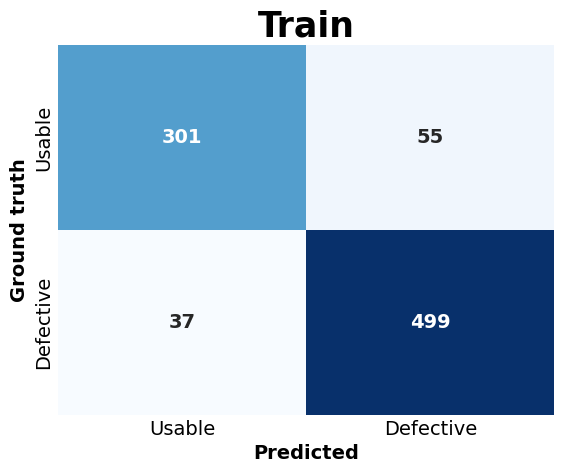

[[301  55]
 [ 37 499]]


In [20]:
train_confusion_matrix = draw_confusion_matrix(
    y_true=y_train_true,
    y_pred=y_train_pred,
    title="Train")
print(train_confusion_matrix)

In [21]:
CONFUSION_TRAIN_FILE = os.path.join(train_outputs_dir, params_train.CONFUSION_TRAIN_FILE)
with open(CONFUSION_TRAIN_FILE, 'wb') as file:
    pickle.dump(train_confusion_matrix, file)

## Validation

In [22]:
y_val_true = valid_set.classes[valid_set.index_array]
y_val_pred = loaded_model.predict(valid_set)

14/14 [==============================] - 0s 27ms/step


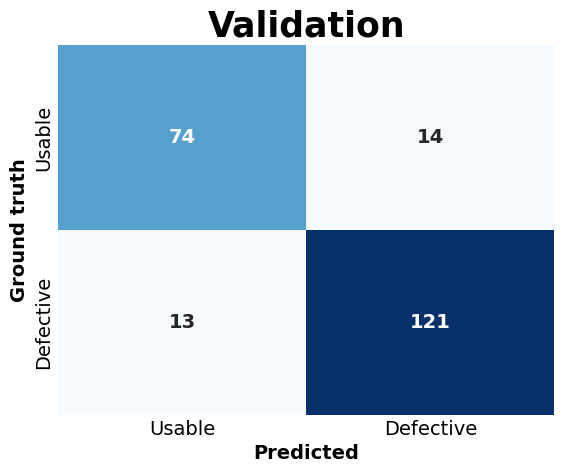

[[ 74  14]
 [ 13 121]]


In [23]:
val_confusion_matrix = draw_confusion_matrix(
    y_true=y_val_true,
    y_pred=y_val_pred,
    title="Validation")
print(val_confusion_matrix)

In [24]:
CONFUSION_VAL_FILE = os.path.join(train_outputs_dir, params_train.CONFUSION_VAL_FILE)
with open(CONFUSION_VAL_FILE, 'wb') as file:
    pickle.dump(val_confusion_matrix, file)

# VISUALIZE ERRORS

In [25]:
def visualize_errors(files_set: list,
                     save_dir: str,
                     number_to_plot: int = 5) -> None:
    """
    Visualize and save predicted errors.
    Return files that the model infered wrong.
    """
    os.makedirs(save_dir, exist_ok=True)
    wrong_inference = list()
    
    FP_count = 0
    FN_count = 0
    for file in files_set:
        ground_truth = int(file.split('/')[-2][0])
        filename = file.split("/")[-1]

        sample = keras.preprocessing.image.load_img(file, grayscale=True)
        sample = keras.preprocessing.image.img_to_array(sample)
        sample = np.expand_dims(sample, 0)
        pred = loaded_model.predict(sample)
        pred = (pred >= model_class.THRESHOLD_DECISION).reshape(-1,)
        
        diff = pred - ground_truth
        # 0 : ok
        # 1 : pred==1, gt==0 -> FP
        # -1: pred==0, gt==1 -> FN

        if diff:
            wrong_inference.append(filename)
            if diff == 1:
                FP_count += 1
                title = "FP"
                count = FP_count
            else:
                FN_count += 1
                title = "FN"
                count = FN_count
                
            image = sample[0, :, :, 0]
            cv2.imwrite(os.path.join(save_dir, filename), image)
            
            if count <= number_to_plot:
                plt.figure(figsize=(3, 3))
                plt.imshow(image, cmap="gray")
                plt.title(title)
                
    plt.show()
    
    wrong_inference = natsort.natsorted(wrong_inference)
    return wrong_inference

1/1 [==============================] - 0s 81ms/step


/home/vuser/Documents/backup_07302023/3_tcc_code/ML_IoT_pipeline/ML_IoT_pipeline/env_ML_pipeline/lib/python3.9/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


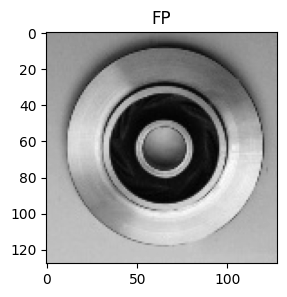

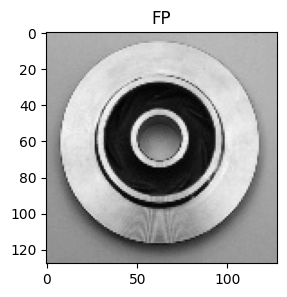

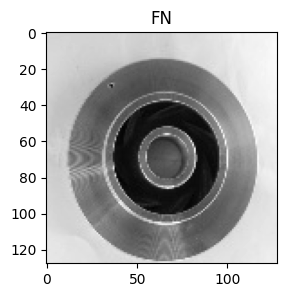

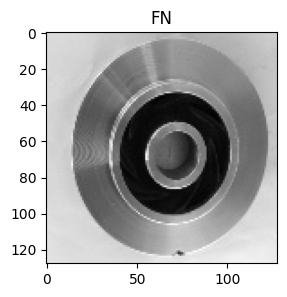

In [26]:
val_errors_dir = os.path.join(train_outputs_dir, params_train.VAL_ERRORS_DIR)

wrong_in_val = visualize_errors(valid_files, val_errors_dir, 2)

1/1 [==============================] - 0s 24ms/step


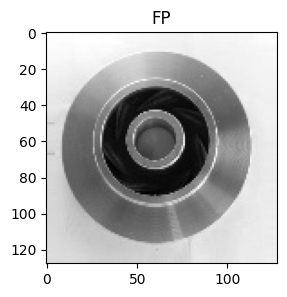

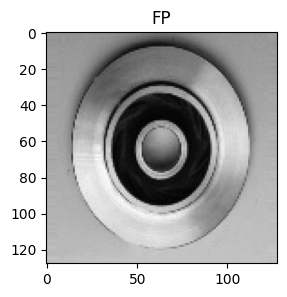

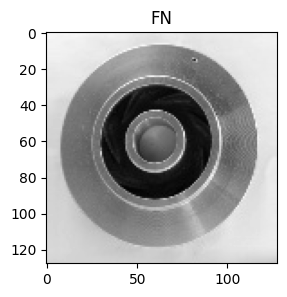

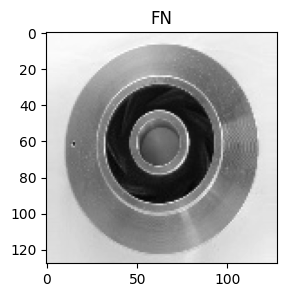

In [27]:
train_errors_dir = os.path.join(train_outputs_dir, params_train.TRAIN_ERRORS_DIR)

wrong_in_train = visualize_errors(train_files, train_errors_dir, 2)

In [28]:
WRONG_TRAIN_FILE = os.path.join(train_outputs_dir, params_train.WRONG_TRAIN_FILE)
WRONG_VAL_FILE = os.path.join(train_outputs_dir, params_train.WRONG_VAL_FILE)

for wrong_files in zip([WRONG_TRAIN_FILE, WRONG_VAL_FILE], [wrong_in_train, wrong_in_val]):
    with open(wrong_files[0], 'wb') as file:
        pickle.dump(wrong_files[1], file)

# FINISH LOG

In [29]:
mlflow.log_artifact(train_outputs_dir)

In [30]:
mlflow.end_run()